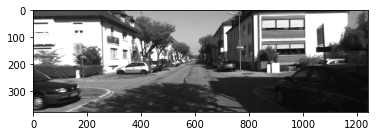

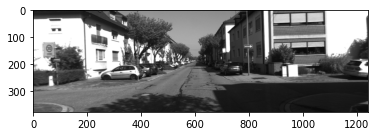

In [11]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2
from IPython.display import Image
from IPython.core.display import HTML 
import pygcransac
from time import time
import urllib.request

# Download the required images
urllib.request.urlretrieve("https://n.ethz.ch/~dbarath/data/kitti_example/004520.png", "img/004520.png")
urllib.request.urlretrieve("https://n.ethz.ch/~dbarath/data/kitti_example/004523.png", "img/004523.png")

K = np.array([[718.856, 0.0, 607.1928],
    [0.0, 718.856, 185.2157],
    [0.0, 0.0, 1.0]])

gravity1 = np.array([[1.0, 0.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 0.0, 1.0]])

gravity2 = np.array([[1.0, 0.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 0.0, 1.0]])

img1 = cv2.cvtColor(cv2.imread('img/004520.png'), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread('img/004523.png'), cv2.COLOR_BGR2RGB)
plt.imshow(img1)
plt.figure()
plt.imshow(img2)

In [12]:
#We will detect ORB features and match them with cross-check test
det = cv2.SIFT_create(8000)    
kps1, descs1 = det.detectAndCompute(img1,None)
kps2, descs2 = det.detectAndCompute(img2,None)

bf = cv2.BFMatcher()

SNN_threshold = 0.8
matches = bf.knnMatch(descs1, descs2, k=2)

# Apply ratio test
snn_ratios = []
tentatives = []
for m, n in matches:
    if m.distance < SNN_threshold * n.distance:
        tentatives.append(m)
        snn_ratios.append(m.distance / n.distance)

sorted_indices = np.argsort(snn_ratios)
tentatives = list(np.array(tentatives)[sorted_indices])

print(f"{len(tentatives)} correspondences are found.")

762 correspondences are found.


In [13]:
#Now, some visualization from OpenCV tutorial
#https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_feature_homography/py_feature_homography.html
#We will draw correspondences found and the geometric transformation between the images.
from copy import deepcopy
def decolorize(img):
    return  cv2.cvtColor(cv2.cvtColor(img,cv2.COLOR_RGB2GRAY), cv2.COLOR_GRAY2RGB)
def draw_matches(kps1, kps2, tentatives, img1, img2, mask):
    matchesMask = mask.ravel().tolist()
    # Blue is estimated, green is ground truth homography
    draw_params = dict(matchColor = (255,255,0), # draw matches in yellow color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
    img_out = cv2.drawMatches(decolorize(img1),kps1,img2,kps2,tentatives,None,**draw_params)
    plt.figure(figsize = (12,8))
    plt.imshow(img_out)
    return

In [14]:
img1.shape

(376, 1241, 3)

543.0 inliers found
0.01067209243774414 sec cv2
658.0 inliers found
0.02803325653076172 sec gc-ransac


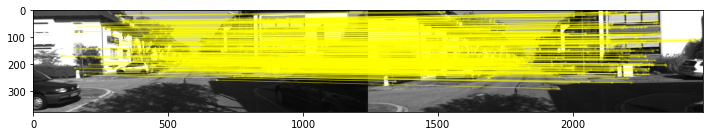

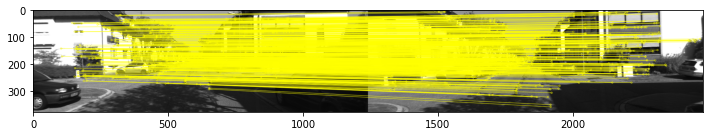

In [15]:
def get_probabilities(tentatives):
    probabilities = []
    # Since the correspondences are assumed to be ordered by their SNN ratio a priori,
    # we just assign a probability according to their order.
    for i in range(len(tentatives)):
        probabilities.append(1.0 - i / len(tentatives))
    return probabilities

def verify_cv2_ess(kps1, kps2, tentatives, K1, K2, h1, w1, h2, w2):
    src_pts = np.float32([ kps1[m.queryIdx].pt for m in tentatives ]).reshape(-1,2)
    dst_pts = np.float32([ kps2[m.trainIdx].pt for m in tentatives ]).reshape(-1,2)
    
    # Normalize the threshold
    threshold = 0.75
    avgDiagonal = (K1[0][0] + K1[1][1] + K2[0][0] + K2[1][1]) / 4; 
    normalizedThreshold = threshold / avgDiagonal
            
    # Normalize the point coordinates
    normalizedSourcePoints = cv2.undistortPoints(np.expand_dims(src_pts, axis=1), cameraMatrix=K1, distCoeffs=None)
    normalizedDestinationPoints = cv2.undistortPoints(np.expand_dims(dst_pts, axis=1), cameraMatrix=K2, distCoeffs=None)
    
    # Estimate the essential matrix from the normalized coordinates
    # using the normalized threshold.
    E, mask = cv2.findEssentialMat(normalizedSourcePoints, 
                                   normalizedDestinationPoints, 
                                   focal=1.0, 
                                   pp=(0., 0.),
                                   method=cv2.RANSAC, 
                                   prob=0.99,
                                   threshold=normalizedThreshold)

    print (deepcopy(mask).astype(np.float32).sum(), 'inliers found')
    return E, mask

def verify_pygcransac_ess(kps1, kps2, tentatives, gravity1, gravity2, K1, K2, h1, w1, h2, w2, sampler_id):

    correspondences = np.float32([ (kps1[m.queryIdx].pt + kps2[m.trainIdx].pt) for m in tentatives ]).reshape(-1,4)
    inlier_probabilities = []

    # NG-RANSAC and AR-Sampler require an inlier probability to be provided for each point.
    # Since deep learning-based prediction is not applied here, we calculate the probabilities
    # from the SNN ratio ranks.  
    if sampler_id == 3 or sampler_id == 4:
        inlier_probabilities = get_probabilities(tentatives)

    E, mask = pygcransac.findGravityEssentialMatrix(
        np.ascontiguousarray(correspondences), # Point correspondences in the two images
        gravity1,
        gravity2,
        K1, # Intrinsic camera parameters of the source image
        K2, # Intrinsic camera parameters of the destination image
        h1, w1, h2, w2, # The sizes of the images
        probabilities = inlier_probabilities, # Inlier probabilities. This is not used if the sampler is not 3 (NG-RANSAC) or 4 (AR-Sampler)
        threshold = 0.75, # Inlier-outlier threshold
        conf = 0.99, # RANSAC confidence
        spatial_coherence_weight = 0.0, # The spatial coherence weight for GC-RANSAC
        sampler = 4) # Sampler index (0 - Uniform, 1 - PROSAC, 2 - P-NAPSAC, 3 - NG-RANSAC, 4 - AR-Sampler)
    print (deepcopy(mask).astype(np.float32).sum(), 'inliers found')
    return E, mask

t=time()
cv2_E, gc_cv2_mask = verify_cv2_ess(kps1, kps2, tentatives, K, K, img1.shape[0],img1.shape[1],
                                   img2.shape[0], img2.shape[1])
print (time()-t, 'sec cv2')

t=time()
gc_E, gc_E_mask = verify_pygcransac_ess(kps1, kps2, tentatives, gravity1, gravity2, K, K, img1.shape[0],img1.shape[1],
                                img2.shape[0], img2.shape[1], 4)
print (time()-t, 'sec gc-ransac')

draw_matches(kps1, kps2, tentatives, img1, img2, gc_cv2_mask)
draw_matches(kps1, kps2, tentatives, img1, img2, gc_E_mask)
